In [2]:
import datetime
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

C:\Users\mrsur\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\mrsur\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [29]:
data1 = pd.read_csv("https://data.covid19india.org/csv/latest/districts.csv")
#data1 = pd.read_csv("C:\districts1.csv")
data1 = data1.drop(['Other','Tested'],axis=1)
data1['Date'] = pd.to_datetime(data1['Date'])
data1 = data1.sort_values(by=['State','District','Date'],inplace=False)
lastdate = data1.iloc[-1]['Date']
lastdate

Timestamp('2021-10-31 00:00:00')

In [31]:
def assignrisk(data):
    #Finding maximum number of confirmed cases and assigning risk percentage
    maximum = data["Confirmed"].max()
    for i,row in data.iterrows():
        data.loc[i,"Risk"] = (row["Confirmed"]/(maximum))*95
    
    #Assigning a category for the risk percentages
    conditions = [
    (data['Risk']<20),
    (data['Risk']<40) & (data['Risk']>20),
    (data['Risk']<60) & (data['Risk']>40),
    (data['Risk']<80) & (data['Risk']>60),
    (data['Risk']>80),
     ]
    values = ['Very Low','Low','Medium','High','Very High']
    data['Category'] = np.select(conditions , values)
    

In [32]:
def getdata(District, reqdate):
    #Filtering the required portion of data (District data only)
    data = data1[data1['District']==District]
    data = data[['Date','Confirmed','Recovered','Deceased']]
    data.index = data['Date']
    data.drop(columns='Date',inplace = True)
    data.parse_dates = True
    assignrisk(data)
    
    fig = plt.figure(figsize=(20,5),dpi=100)
    plt.title("Confirmed COVID cases")
    casesplot = sns.lineplot(data=data, x= 'Date', y = 'Confirmed')
    
    record = data[data.index == str(reqdate)]
    
    cases = record['Confirmed'].values
    recovered = record['Recovered'].values
    deceased = record['Deceased'].values
    risk = record['Risk'].values
    risk_cat = record['Category'].values
    
    
    #Printing the values
    print("Confirmed cases on " + str(reqdate) + " is " + str(cases).strip('[]'))
    print("Recovered cases on " + str(reqdate) + " is " + str(recovered).strip('[]'))
    print("Deceased cases on " + str(reqdate) + " is " + str(deceased).strip('[]'))
    print("Percentage risk of virus is " + str(risk).strip('[]') + "%")
    print("Predicted impact of the virus is " + str(risk_cat).strip('[]'))
    
    

In [33]:
def forecast(District, Forecast_Date):
    #Filtering the required portion of data (District data only)
    data = data1[data1['District']==District]
    
    assignrisk(data)
    
    plotting(data)
    
    #Making a copy of the data and performing and manipulating it for forecasting
    data2 = data
    data2 = data2[['Date','Confirmed']]
    data2.index = data2['Date']
    data2.drop(columns='Date',inplace = True)
    data2.parse_dates = True
    
    #Using Holt Winters Triple Exponential Smoothing as the forecasting model
    fig = plt.figure(figsize=(20,5),dpi=100)
    fitted_model = ExponentialSmoothing(data2['Confirmed'],trend='add',seasonal = 'add',seasonal_periods = 7).fit()
    test_predictions = fitted_model.forecast(90)
    test_predictions.index = pd.date_range(start=lastdate,periods = 90)

    #Plotting confirmed cases of already available data along with a 3 month forecast
    dataplot = data2['Confirmed'].plot(legend=True,label='Actual')
    forecastplot = test_predictions.plot(legend=True,label='Predicted')
    plt.title('COVID 19 Cases Prediction with 3 month forecast')
    
    #Merging actual and forecasted data
    test_predictions = pd.DataFrame(test_predictions)
    test_predictions.index.rename('Date', inplace=True)
    test_predictions.columns = ['Confirmed']
    data2 = data2.append(test_predictions)
    assignrisk(data2)
    
    #Retreiving the information of the queried forecast date
    forecast_record = data2[data2.index == str(Forecast_Date)]
    forecast_cases = forecast_record['Confirmed'].values
    forecast_risk = forecast_record['Risk'].values
    forecast_risk_cat = forecast_record['Category'].values
    
    
    #Printing the values
    print("Predicted confirmed cases on " + str(Forecast_Date) + " is " + str(forecast_cases).strip('[]'))
    print("Risk for touring is " + str(forecast_risk).strip('[]') + "%")
    print("Predicted impact of the virus is " + str(forecast_risk_cat).strip('[]'))
    

In [34]:
def plotting(data):
    
    #plot of confirmed cases of already available data
    fig = plt.figure(figsize=(20,5),dpi=100)
    plt.title("Confirmed COVID cases")
    casesplot = sns.lineplot(data=data, x= 'Date', y = 'Confirmed')
    

Confirmed cases on 2020-01-07 is 
Recovered cases on 2020-01-07 is 
Deceased cases on 2020-01-07 is 
Percentage risk of virus is %
Predicted impact of the virus is 


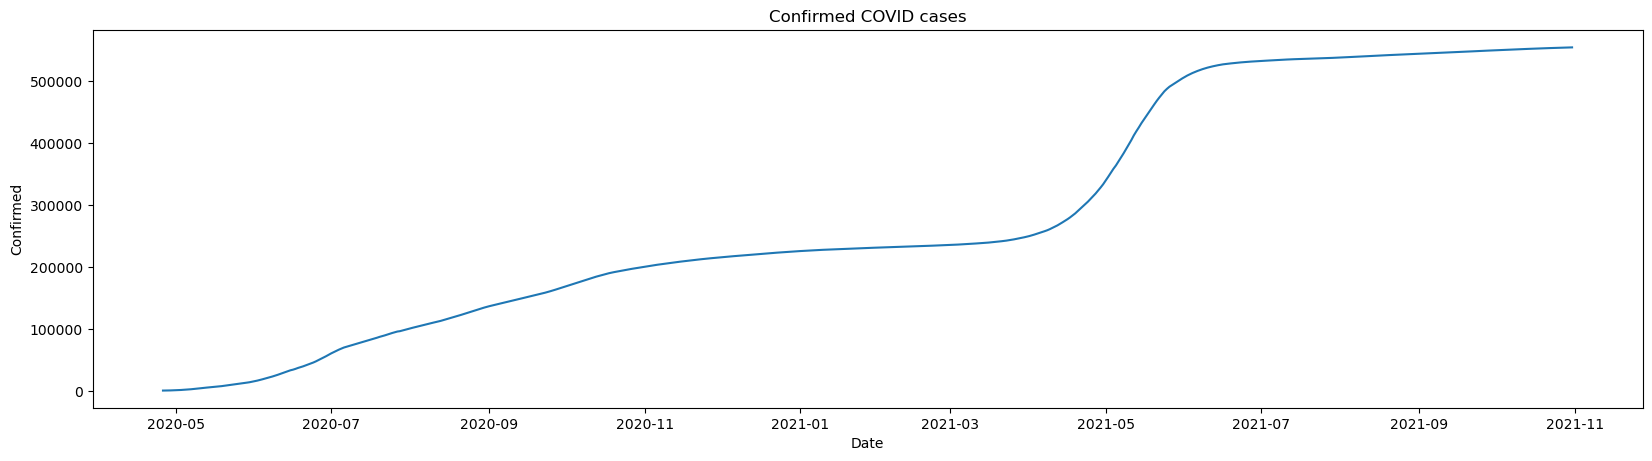

In [35]:
getdata("Chennai","2020-01-07")

<ipython-input-31-f4239dd9fb5c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[i,"Risk"] = (row["Confirmed"]/(maximum))*95
<ipython-input-31-f4239dd9fb5c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Category'] = np.select(conditions , values)
<ipython-input-33-351756d46022>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Predicted confirmed cases on 2022-02-03 is 
Risk for touring is %
Predicted impact of the virus is 


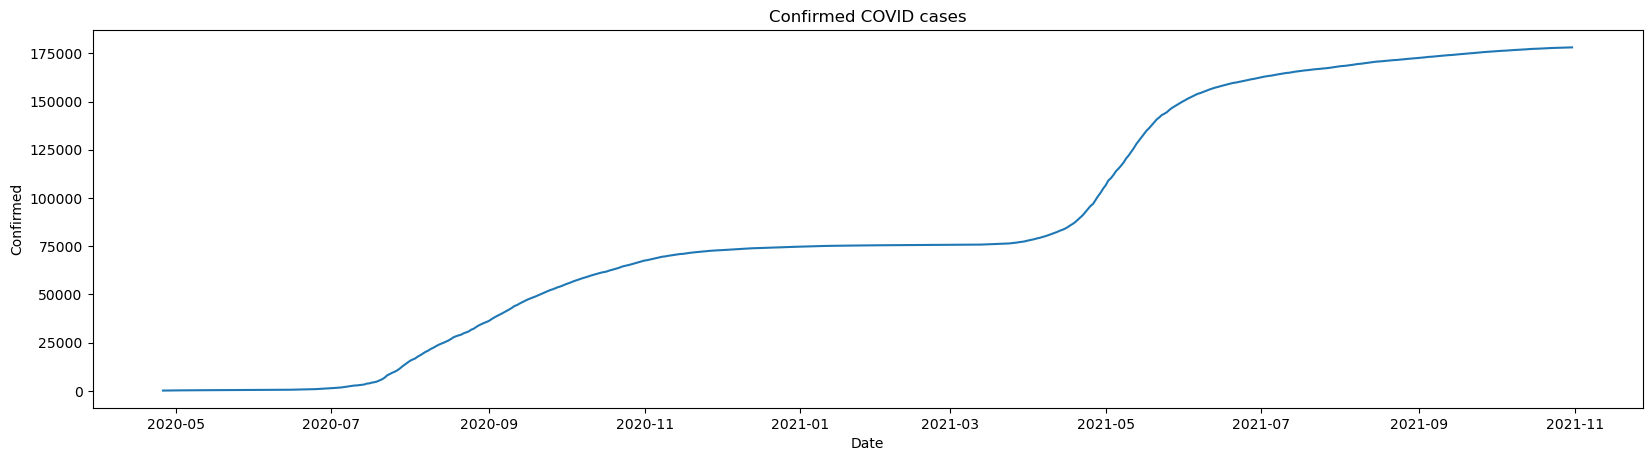

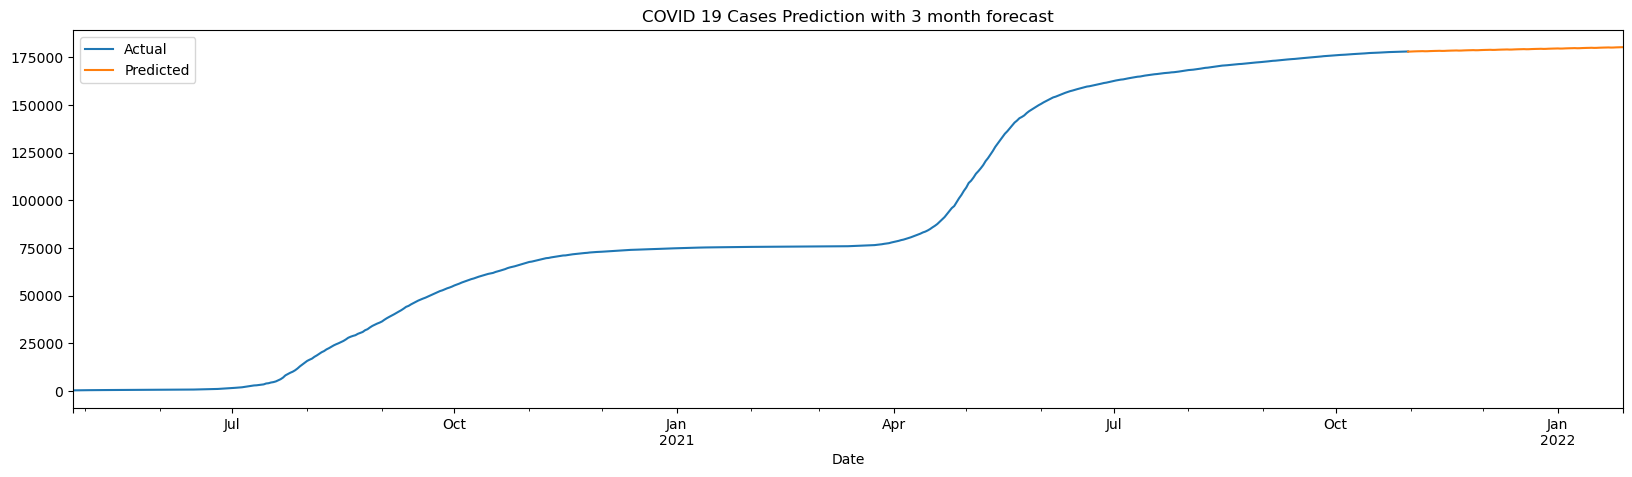

In [36]:
forecast("Guntur","2022-02-03")